#**Collecting Data**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [9]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [12]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 94% 353M/376M [00:06<00:00, 47.0MB/s]
100% 376M/376M [00:06<00:00, 61.7MB/s]


In [14]:
# !cp -v -r "/content/animal-image-datasetdog-cat-and-panda.zip" "/content/drive/MyDrive"

In [ ]:
!unzip \*.zip  && rm *.zip

In [10]:
print("No of Panda Images:",len(os.listdir("/content/animals/animals/panda")))
print("No of Cat Images:",len(os.listdir("/content/animals/animals/cats")))
print("No of Dog Images:",len(os.listdir("/content/animals/animals/dogs")))

No of Panda Images: 1000
No of Cat Images: 1000
No of Dog Images: 1000


#**Preprocessing Data**

In [44]:
!rm -rf "/content/animals/images/.ipynb_checkpoints"
os.listdir("/content/animals/images")

['dogs', 'cats', 'panda']

In [23]:
import cv2

image = cv2.imread("/content/animals/animals/cats/cats_00001.jpg")
print(image.shape)

(374, 500, 3)


#**Designing CNN**

In [45]:
from keras.applications.vgg16 import VGG16

img_rows, img_cols = 224, 224

model = VGG16(weights='imagenet',
              include_top=False,
              input_shape = (img_rows, img_cols, 3))

In [46]:
for layer in model.layers:
  layer.trainable = False

In [47]:
# view the structure of the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
def layer_adder(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model


num_classes = 3

FC_Head = layer_adder(model, num_classes)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    rotation_range=90,
    vertical_flip=True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
)

validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = training_datagen.flow_from_directory(
      "/content/animals/animals",  
      target_size=(224, 224), 
      batch_size=32,
      shuffle=True,
      class_mode='categorical')


val_generator = validation_datagen.flow_from_directory(
      "/content/animals/images",  
      target_size=(224, 224),
      batch_size=32,
      shuffle=True,
      class_mode='categorical')

Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [51]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

In [52]:
history = model.fit_generator(train_generator,
                              epochs = 10,
                              callbacks=callbacks,
                              validation_data=val_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
94/94 [==============================] - 58s 607ms/step - loss: 1.1031 - accuracy: 0.4165 - val_loss: 0.6932 - val_accuracy: 0.7000

Epoch 00001: val_loss improved from inf to 0.69324, saving model to model.h5
Epoch 2/10
94/94 [==============================] - 57s 606ms/step - loss: 0.8096 - accuracy: 0.6210 - val_loss: 0.5092 - val_accuracy: 0.7733

Epoch 00002: val_loss improved from 0.69324 to 0.50919, saving model to model.h5
Epoch 3/10
94/94 [==============================] - 57s 603ms/step - loss: 0.7303 - accuracy: 0.6616 - val_loss: 0.4153 - val_accuracy: 0.8350

Epoch 00003: val_loss improved from 0.50919 to 0.41532, saving model to model.h5
Epoch 4/10
94/94 [==============================] - 56s 600ms/step - loss: 0.6747 - accuracy: 0.6936 - val_loss: 0.3834 - val_accuracy: 0.8480

Epoch 00004: val_loss improved from 0.41532 to 0.38340, saving model to model.h5
Epoch 5/10
94/94 [==============================] - 57s 604ms/step - loss: 0.7148 - accuracy: 0.6745 - v

In [53]:
import matplotlib.pyplot as plt

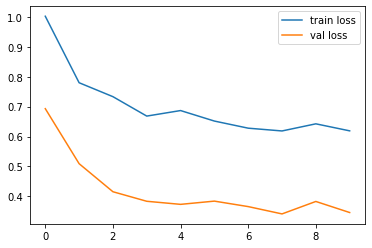

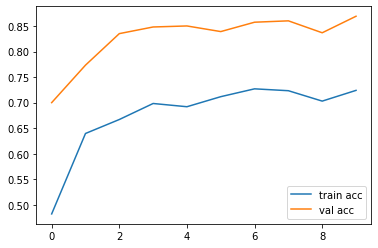

In [54]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [55]:
from keras.models import load_model

In [56]:
cnn = load_model("/content/model.h5")

In [57]:
train_generator.class_indices

{'cats': 0, 'dogs': 1, 'panda': 2}

In [63]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img("/content/ss-160826-twip-05_8cf6d4cb83758449fd400c7c3d71aa1f.fit-760w.jpg", target_size=(224,224))


test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

In [64]:
result

array([[0., 0., 1.]], dtype=float32)